# Purpose of This Notebook - Features Selection

This notebook performs feature selection using both LASSO logistic regression and XGBoost-based importance ranking.
The goal is to identify a minimal but clinically meaningful variable set for predicting early distant recurrence in stage III colon cancer.
The dataset required for running this notebook is not included due to privacy restrictions.
Please place your dataset under ./data/ before executing the code.

## 1. Environment Setup and Import Libraries

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, 
    average_precision_score, brier_score_loss,
    confusion_matrix, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.special import logit
from scipy import stats
import warnings

## 2. Read Parquet for Analysis

In [3]:
df=pd.read_parquet('/Users/huangshifeng/Desktop/stage_III_colon_surv/data/post_EDA.parquet', engine='pyarrow')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Patient_ID            331 non-null    int64         
 1   Dx_Year               331 non-null    int64         
 2   Age                   331 non-null    int64         
 3   Sex                   331 non-null    int64         
 4   BMI                   327 non-null    float64       
 5   ECOG                  314 non-null    Int8          
 6   Tumor_Location        331 non-null    int64         
 7   Tumor_Location_Group  331 non-null    int64         
 8   pT_Stage              331 non-null    category      
 9   pN_Stage              331 non-null    category      
 10  AJCC_Substage         331 non-null    category      
 11  LN_Total              331 non-null    int64         
 12  LN_Positive           331 non-null    int64         
 13  LNR                 

## 3. Preprocessing

### Dealing with dTypes

In [4]:
#'LNR': object -> float
df['LNR']=df['LNR'].str.replace('%', '')
df['LNR']=round((df['LNR'].astype(float))/100, 3)

#'Sex' mapping 1(Male)/2(Female) to 0(Female)/1(Male)
df['Sex']=df['Sex'].astype(str).str.replace('2', '0')
df['Sex']=df['Sex'].astype('int64')

#'Tumor_Location_Group' mapping 1(Right)/2(Left)，要改成0(Right)/1(Left)
df['Tumor_Location_Group']=df['Tumor_Location_Group'].astype(str).str.replace('1', '0')
df['Tumor_Location_Group']=df['Tumor_Location_Group'].astype(str).str.replace('2', '1')
df['Tumor_Location_Group']=df['Tumor_Location_Group'].astype('int64')

#'LVI', 'PNI', 'ECOG', 'edr_18m', 'edr_24m' to Int
df['LVI']=df['LVI'].astype('Int64')
df['PNI']=df['PNI'].astype('Int64')
df['ECOG']=df['ECOG'].astype('Int64')
df['edr_18m']=df['edr_18m'].astype('Int64')
df['edr_24m']=df['edr_24m'].astype('Int64')

#'Differentiation': 9 -> NaN
df['Differentiation']=df['Differentiation'].replace(9, np.nan)
df['Differentiation']=df['Differentiation'].astype('Int64')

0    0.706
1    0.059
2    0.000
3    0.176
4    0.167
Name: LNR, dtype: float64


In [5]:
#Turn MSI_Status into binary column MSI_High(0/1)
df=df.rename(columns={'MSI_Status':'MSI_High'})
df['MSI_High']=df['MSI_High'].str.replace('MSI-H', '1')
df['MSI_High']=df['MSI_High'].str.replace('MSS', '0')
df['MSI_High']=df['MSI_High'].astype('Int64')
df['MSI_High'].value_counts(dropna=False)

MSI_High
0       303
1        26
<NA>      2
Name: count, dtype: Int64

In [6]:
df['Tumor_Location_Group'].value_counts(dropna=False)

Tumor_Location_Group
1    216
0    115
Name: count, dtype: int64

### Define Features

In [7]:
#ordinal orders mapping numericals for LASSO Logistic
# pT_Stage Mapping
t_mapping = {
    '1': 1, 
    '2': 2, 
    '3': 3, 
    '4A': 4, 
    '4B': 5
}

df['pT_Stage_Num'] = df['pT_Stage'].astype(str).map(t_mapping)
df['pT_Stage_Num']=df['pT_Stage_Num'].astype('Int64')

# pN_Stage Mapping
n_mapping = {
    '1A': 1, 
    '1B': 2, 
    '1C': 3,
    '2A': 4, 
    '2B': 5
}

df['pN_Stage_Num'] = df['pN_Stage'].astype(str).map(n_mapping)
df['pN_Stage_Num']=df['pN_Stage_Num'].astype('Int64')

# C. AJCC_Substage Mapping
ajcc_mapping = {
    '3A': 1, 
    '3B': 2, 
    '3C': 3
}
df['AJCC_Substage_Num'] = df['AJCC_Substage'].astype(str).map(ajcc_mapping)
df['AJCC_Substage_Num']=df['AJCC_Substage_Num'].astype('Int64')

# Output prepare for ML parquet
df.to_parquet('/Users/huangshifeng/Desktop/stage_III_colon_surv/data/all_cases_prepared_for_ML.parquet', engine='pyarrow')

In [8]:
num_features = [
    'Age', 'BMI', 'LN_Total', 'LN_Positive', 
    'Tumor_Size_cm', 'PreOp_Albumin', 'Log_CEA_PreOp', 'LNR', 'pT_Stage_Num', 'pN_Stage_Num', 'AJCC_Substage_Num', 'ECOG', 'Differentiation'
]
bin_features = [
    'Sex', 'LVI', 'PNI', 'Tumor_Deposits', 
    'Mucinous_Any', 'Signet_Ring', 'Tumor_Location_Group', 'MSI_High'
]

nom_features = ['Histology']

target_col = 'edr_18m'
total_features = num_features + bin_features + nom_features

## 4. Establish Pipeline

In [9]:
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)), 
    ('scaler', StandardScaler())
])

bin_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

nom_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('bin', bin_transformer, bin_features),
        ('nom', nom_transformer, nom_features)
    ],
    remainder='drop'
)

## 5. LASSO Model for Features Selection

In [10]:
lasso_model = LogisticRegressionCV(
    cv=5,
    penalty='l1',
    solver='saga', 
    class_weight='balanced', 
    random_state=8251,
    max_iter=10000, 
    scoring='roc_auc',
    Cs=np.logspace(-2, 1, 8)
)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lasso_model)])

### Fit LASSO Model

In [16]:
warnings.filterwarnings("ignore")

X=df[total_features]
y=df[target_col]

clf.fit(X, y)

print("LASSO with precise encoding finished.")

print("Picked C：", lasso_model.C_)
print("Shape：", lasso_model.coef_.shape)
print("Intercept：", lasso_model.intercept_)

# 1. Extract preprocessor and LASSO model
preprocessor = clf.named_steps['preprocessor']
lasso_model = clf.named_steps['classifier']

# 2. Get feature names
feature_names = preprocessor.get_feature_names_out()
coefs = lasso_model.coef_.ravel()

# 3. Form a table and calculate absolute value for 
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs,
    'abs_coef': np.abs(coefs)
})

# 5. Sorting
coef_df_sorted = coef_df.sort_values('abs_coef', ascending=False)

# 6. Filter for LASSO-filtered features (coefficient ≠ 0）
nonzero_coef_df = coef_df_sorted[coef_df_sorted['coef'] != 0]

print("All variables（including those with coefficient =0")
display(coef_df_sorted)

print("LASSO-filtered varibales（coef ≠ 0） ===")
display(nonzero_coef_df)


LASSO with precise encoding finished.
Picked C： [0.02682696]
Shape： (1, 24)
Intercept： [-0.07343315]
All variables（including those with coefficient =0


,feature,coef,abs_coef
10,num__AJCC_Substage_Num,0.30607,0.30607
0,num__Age,0.00000,0.00000
13,bin__Sex,0.00000,0.00000
22,nom__Histology_2,0.00000,0.00000
21,nom__Histology_1,0.00000,0.00000
20,bin__MSI_High,0.00000,0.00000
19,bin__Tumor_Location_Group,0.00000,0.00000
18,bin__Signet_Ring,0.00000,0.00000
17,bin__Mucinous_Any,0.00000,0.00000
16,bin__Tumor_Deposits,0.00000,0.00000


LASSO-filtered varibales（coef ≠ 0） ===


,feature,coef,abs_coef
10,num__AJCC_Substage_Num,0.30607,0.30607


#### As LASSO regression selected only AJCC substage as a non-zero predictor, we relied on XGBoost-based variable importance to prioritize additional clinicopathologic features for inclusion in the final model.

### XGBoost for Features Selection

Fold 1/5 Completed
Fold 2/5 Completed
Fold 3/5 Completed
Fold 4/5 Completed
Fold 5/5 Completed

【XGBoost (5-Fold CV) Features Importance】


,Feature,Importance_Mean,Importance_Std
10,AJCC_Substage_Num,0.148797,0.119139
15,PNI,0.079589,0.037684
3,LN_Positive,0.061975,0.025355
11,ECOG,0.058342,0.019453
7,LNR,0.056572,0.011550
2,LN_Total,0.053420,0.009881
4,Tumor_Size_cm,0.051380,0.009441
12,Differentiation,0.049441,0.038382
0,Age,0.048429,0.011656
6,Log_CEA_PreOp,0.047920,0.008460


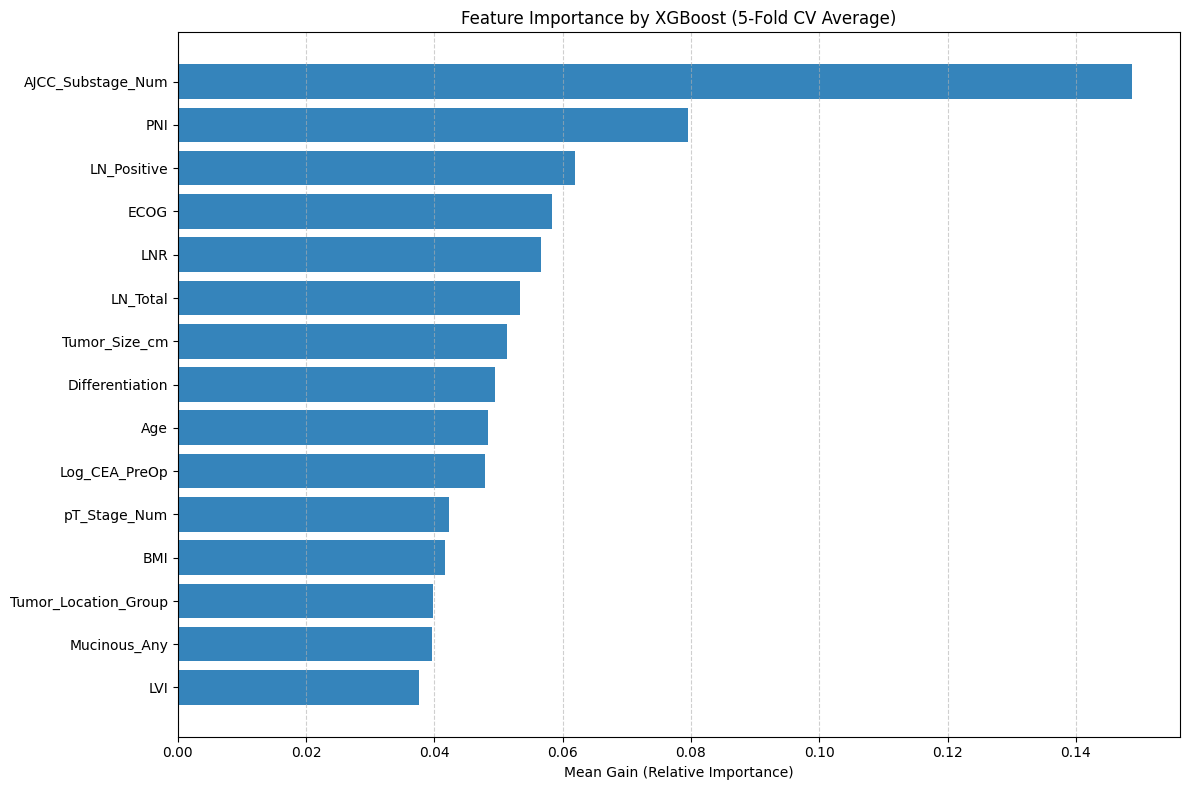

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

# ==========================================
# XGBoost with 5-Fold CV
# ==========================================

# 1. StratifiedKFold CV 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=8251)

# A list to store feature importance
feature_importance_collection = []


# 2. Start CV Loops
# Input X (DataFrame) and y (Series)
for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    
    # Train/test split
    X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
    
    # Modeling
    # scale_pos_weight: using y_train of the fold
    scale_weight = (len(y_train_fold) - sum(y_train_fold)) / sum(y_train_fold)
    
    xgb_selector = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        scale_pos_weight=scale_weight, 
        random_state=8251,
        n_jobs=-1,
        eval_metric='auc'
    )

    # Establishing Pipeline
    xgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb_selector)
    ])
    
    # Fit on X_train_fold
    xgb_pipeline.fit(X_train_fold, y_train_fold)
    
    # Feature name extraction
    if i == 0:
        try:
            nom_names = xgb_pipeline.named_steps['preprocessor'].transformers_[2][1]\
                .named_steps['onehot'].get_feature_names_out(nom_features)
            all_feature_names = np.r_[num_features, bin_features, nom_names]
        except Exception as e:
            print(f"Feature name extraction fails, error: {e}")
            # Fallback number-indexing
            num_feats = len(xgb_pipeline.named_steps['classifier'].feature_importances_)
            all_feature_names = [f"Feat_{j}" for j in range(num_feats)]

    # Fold importance extraction
    fold_importances = xgb_pipeline.named_steps['classifier'].feature_importances_
    feature_importance_collection.append(fold_importances)
    
    print(f"Fold {i+1}/5 Completed")

# 3. Results

# Turn the list into numpy array (Shape: 5 x n_features)
importance_matrix = np.array(feature_importance_collection)

# Calculate mean and SD
mean_importances = np.mean(importance_matrix, axis=0)
std_importances = np.std(importance_matrix, axis=0)

# Turn into Dataframe for display
xgb_cv_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance_Mean': mean_importances,
    'Importance_Std': std_importances
}).sort_values(by='Importance_Mean', ascending=False)

print("\n【XGBoost (5-Fold CV) Features Importance】")
display(xgb_cv_df.head(15))


# 4. Visualization 
# Top 15 Features
top15_df = xgb_cv_df.head(15).copy()
top15_df = top15_df.sort_values(by='Importance_Mean', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(
    y=top15_df['Feature'],
    width=top15_df['Importance_Mean'],
    capsize=5,
    alpha=0.9
)

plt.title('Feature Importance by XGBoost (5-Fold CV Average)')
plt.xlabel('Mean Gain (Relative Importance)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()